In [18]:

import re
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors
from Levenshtein import distance as lev
from rdkit import rdBase
from rdkit import RDLogger
from rdkit import Chem
rdBase.DisableLog('rdApp.error')
RDLogger.DisableLog('rdApp.warning')
RDLogger.DisableLog('rdApp.*')
from EFGs import mol2frag
from rdkit import Chem
from collections import Counter

def extract_solution(solution_str: str) -> str:
    """
    Extract the last <answer>...</answer> block from the solution string.
    """
    matches = list(re.finditer(r"<answer>(.*?)</answer>", solution_str, re.DOTALL))
    return matches[-1].group(1).strip() if matches else None


def is_valid_smiles(smi: str) -> bool:
    try:
        mol = Chem.MolFromSmiles(smi)
        return mol is not None
    except:
        return False


def exact_string_match(pred_smi: str, gt_smi: str) -> float:
    try:
        can_pred = Chem.MolToSmiles(Chem.MolFromSmiles(pred_smi), canonical=True)
        can_gt = Chem.MolToSmiles(Chem.MolFromSmiles(gt_smi), canonical=True)
        return 1.0 if can_pred == can_gt else 0.0
    except:
        return 0.0


def exact_structure_match(pred_smi: str, gt_smi: str) -> float:
    try:
        m1, m2 = Chem.MolFromSmiles(pred_smi), Chem.MolFromSmiles(gt_smi)
        return 1.0 if Chem.MolToInchi(m1) == Chem.MolToInchi(m2) else 0.0
    except:
        return 0.0


def property_similarity(pred_smi: str, gt_smi: str) -> float:
    try:
        mol1, mol2 = Chem.MolFromSmiles(pred_smi), Chem.MolFromSmiles(gt_smi)
        props1 = np.array([Descriptors.MolWt(mol1), Descriptors.MolLogP(mol1), Descriptors.TPSA(mol1)])
        props2 = np.array([Descriptors.MolWt(mol2), Descriptors.MolLogP(mol2), Descriptors.TPSA(mol2)])
        diff = np.abs(props1 - props2)
        return float(np.exp(-np.mean(diff) / 10))
    except:
        return 0.0


def fingerprint_similarity_scores(pred_smi: str, gt_smi: str):
    try:
        mol1, mol2 = Chem.MolFromSmiles(pred_smi), Chem.MolFromSmiles(gt_smi)
        maccs_sim = DataStructs.FingerprintSimilarity(MACCSkeys.GenMACCSKeys(mol1), MACCSkeys.GenMACCSKeys(mol2))
        rdk_sim = DataStructs.FingerprintSimilarity(Chem.RDKFingerprint(mol1), Chem.RDKFingerprint(mol2))
        morgan_sim = DataStructs.TanimotoSimilarity(
            AllChem.GetMorganFingerprint(mol1, 2),
            AllChem.GetMorganFingerprint(mol2, 2)
        )
        return maccs_sim, rdk_sim, morgan_sim
    except:
        return 0.0, 0.0, 0.0


def smiles_levenshtein(pred_smi: str, gt_smi: str, normalize_len: int = 100) -> float:
    try:
        return 1.0 - lev(pred_smi, gt_smi) / normalize_len
    except:
        return 0.0


# def compute_score(solution_str: str, ground_truth: str) -> float:
    
#     pred_smi = extract_solution(solution_str)
#     if pred_smi is None:
#         return 0.0  

#     if not is_valid_smiles(pred_smi):
#         return 0.0  
    
#     exact_text = exact_string_match(pred_smi, ground_truth)
#     exact_struct = exact_structure_match(pred_smi, ground_truth)
#     prop_sim = property_similarity(pred_smi, ground_truth)
#     maccs_sim, rdk_sim, morgan_sim = fingerprint_similarity_scores(pred_smi, ground_truth)
#     lev_sim = smiles_levenshtein(pred_smi, ground_truth)

#     weights = {
#         "exact_text_match": 0.85, # 
#         "exact_struct_match": 0.1,
#         # "morgan_similarity": 0.15,
#         # "property_similarity": 0.1,
#         # "smiles_levenshtein": 0.05,
#         # "rdk_similarity": 0.05,
#         # "maccs_similarity": 0.05,
#         "format_text": 0.05,
#     }

#     score = (
#         weights["exact_text_match"] * exact_text +
#         weights["exact_struct_match"] * exact_struct +
#         # weights["property_similarity"] * prop_sim +
#         # weights["morgan_similarity"] * morgan_sim +
#         # weights["rdk_similarity"] * rdk_sim +
#         # weights["maccs_similarity"] * maccs_sim +
#         # weights["smiles_levenshtein"] * lev_sim + 
#         weights["format_text"] * 1
#     )
    
#     return float(score)
def compute_fragment_overlap(pred_smi: str, gt_smi: str) -> float:
    try:
        mol_pred = Chem.MolFromSmiles(pred_smi)
        mol_gt = Chem.MolFromSmiles(gt_smi)
        if mol_pred is None or mol_gt is None:
            return 0.0

        pred_nonCHs, pred_CHs = mol2frag(mol_pred)
        gt_nonCHs, gt_CHs = mol2frag(mol_gt)

        pred_frags = set(pred_nonCHs + pred_CHs)
        gt_frags = set(gt_nonCHs + gt_CHs)

        if not pred_frags or not gt_frags:
            return 0.0

        intersect = pred_frags & gt_frags
        union = pred_frags | gt_frags
        return len(intersect) / len(union)
    except Exception as e:
        print(f"[fragment reward error] {e}")
        return 0.0
def fragment_recall(pred_smi: str, gt_smi: str) -> float:
    try:
        mol_pred = Chem.MolFromSmiles(pred_smi)
        mol_gt = Chem.MolFromSmiles(gt_smi)
        pred_nonCHs, pred_CHs = mol2frag(mol_pred)
        gt_nonCHs, gt_CHs = mol2frag(mol_gt)
        pred_frags = set(pred_nonCHs + pred_CHs)
        gt_frags = set(gt_nonCHs + gt_CHs)
        if not gt_frags:
            return 0.0
        return len(pred_frags & gt_frags) / len(gt_frags)
    except:
        return 0.0


def functional_group_count_diff(pred_smi: str, gt_smi: str) -> float:
    try:
        mol1 = Chem.MolFromSmiles(pred_smi)
        mol2 = Chem.MolFromSmiles(gt_smi)
        pred_nonCHs, _ = mol2frag(mol1)
        gt_nonCHs, _ = mol2frag(mol2)
        pred_count = Counter(pred_nonCHs)
        gt_count = Counter(gt_nonCHs)
        all_keys = set(pred_count) | set(gt_count)
        diff_sum = sum(abs(pred_count[k] - gt_count[k]) for k in all_keys)
        total = sum(gt_count.values()) + 1e-5
        return float(np.exp(-diff_sum / total))  # 差异越小，reward 越高
    except:
        return 0.0


def compute_score(solution_str: str, ground_truth: str) -> float:
    pred_smi = extract_solution(solution_str)
    if pred_smi is None or not is_valid_smiles(pred_smi):
        return 0.0

    exact_text = exact_string_match(pred_smi, ground_truth)
    exact_struct = exact_structure_match(pred_smi, ground_truth)
    maccs_sim, rdk_sim, morgan_sim = fingerprint_similarity_scores(pred_smi, ground_truth)
    fp_score = 0.5 * morgan_sim + 0.25 * maccs_sim + 0.25 * rdk_sim

    frag_jaccard = compute_fragment_overlap(pred_smi, ground_truth)
    frag_recall_score = fragment_recall(pred_smi, ground_truth)
    frag_score = 0.5 * frag_jaccard + 0.5 * frag_recall_score

    group_score = functional_group_count_diff(pred_smi, ground_truth)

    if exact_text == 1.0:
        return 1.0
    elif exact_struct == 1.0:
        return 0.9
    else:
        return 0.1 + 0.3 * fp_score + 0.3 * frag_score + 0.3 * group_score

In [3]:
from IPython.display import SVG, Image
from rdkit import Chem
from rdkit.Chem import rdDepictor,Descriptors
from rdkit.Chem.Draw import rdMolDraw2D
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import re
from EFGs import mol2frag
def prettymol(smiles, asMol=False, label=None, path='', imgsize=(300, 200), highlights=None):
    '''
    highlights is a dictionary, which may contains:
    highlightAtoms: list
    highlightBonds: list
    highlightAtomRadii: dict[int]=float, atom index (int), radius (float)
    highlightAtomColors: dict[int]=tuple, index (int), color (tuple, length=3)
    highlightBondColors: dict[int]=tuple,index (int), color (tuple, length=3)
    '''
    if asMol:
        mol = smiles.__copy__()
    else:
        mol = Chem.MolFromSmiles(smiles)
    try:
        mol = rdMolDraw2D.PrepareMolForDrawing(mol)
        if '.png' in path:
            drawer = rdMolDraw2D.MolDraw2DCairo(*imgsize)
        else:
            drawer = rdMolDraw2D.MolDraw2DSVG(*imgsize)
        opts = drawer.drawOptions()
        if label == 'map':
            for i in range(mol.GetNumAtoms()):
                opts.atomLabels[i] = mol.GetAtomWithIdx(
                    i).GetSymbol()+str(mol.GetAtomWithIdx(i).GetAtomMapNum())
        if label == 'idx':
            for i in range(mol.GetNumAtoms()):
                opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()+str(i)
        if not highlights:
            drawer.DrawMolecule(mol)
        else:
            drawer.DrawMolecule(mol, **highlights)
        drawer.FinishDrawing()
        if '.png' in path:
            drawer.WriteDrawingText(path)
            display(Image(path))
        else:
            svg = drawer.GetDrawingText()
            display(SVG(svg.replace('svg:','')))
            if '.svg' in path:
                with open(path, 'w') as wf:
                    print(svg, file=wf)
        return drawer
    except Exception as e:
        print("Check your molecule!!!",e)
        return

In [19]:
test_smi = '  <answer> CC/C=C\\CC/C=C\\CC/C=C\\CC/C=C\\CC/C=C\\CC/C=C\\C(C)(C)C(=O)OC[C@H](CO)O[C@@H](O)C[C@@H](O)[C@H](O)[C@H](O)CC(=O)O </answer>'
gt_smi = 'CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\COP(=O)(O)O[C@@H]1O[C@H](C(=O)O)[C@H](O)[C@H](O)[C@H]1O'

compute_score(test_smi, gt_smi)


0.5970159904032096

In [20]:
compute_fragment_overlap(extract_solution(test_smi), gt_smi)

0.7

In [21]:
fingerprint_similarity_scores(extract_solution(test_smi), gt_smi)

(0.5344827586206896, 0.35690968443960824, 0.18213058419243985)

In [22]:
test_smi = ' <answer>  CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\COP(=O)(O)O[C@@H]1O[C@H](C(=O)O)[C@H](O)[C@H](O)[C@H]1O  </answer>'
gt_smi = 'CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\CC/C(C)=C\\COP(=O)(O)O[C@@H]1O[C@H](C(=O)O)[C@H](O)[C@H](O)[C@H]1O'

compute_score(test_smi, gt_smi)


1.0

/tmp/ipykernel_1028582/1204710708.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_cmap = cm.get_cmap('cool')


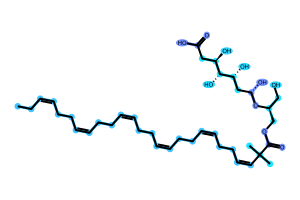

In [4]:
my_cmap = cm.get_cmap('cool')
patt = r'[C,H][0-9]{2}[0,-1,1]'
# Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=0, vmax=100)

smiles = test_smi
mol = Chem.MolFromSmiles(smiles)

a,b,c,d = mol2frag(mol, returnidx=True)
atommap,bondmap = {}, {}
for s,i in zip(a+b, c+d):
    if re.match(patt, s):
        m = Chem.MolFromSmiles(s[0])
    else:
        m = Chem.MolFromSmiles(s)
    mw = Descriptors.HeavyAtomMolWt(m)
    atommap.update({x:my_cmap(my_norm(mw))[:3] for x in i})

for b in mol.GetBonds():
    if atommap[b.GetBeginAtomIdx()] == atommap[b.GetEndAtomIdx()]:
        bondmap[b.GetIdx()]=atommap[b.GetBeginAtomIdx()]

highlights = {
    "highlightAtoms": list(atommap.keys()),
    "highlightAtomColors": atommap,
    "highlightBonds": list(bondmap.keys()),
    "highlightBondColors": bondmap,
}

prettymol(smiles, highlights=highlights,path='sample_mol.png')

/tmp/ipykernel_1028582/3439270677.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_cmap = cm.get_cmap('cool')


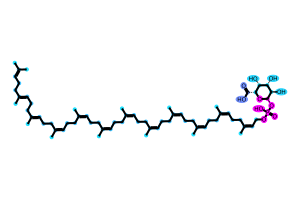

In [5]:
my_cmap = cm.get_cmap('cool')
patt = r'[C,H][0-9]{2}[0,-1,1]'
# Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=0, vmax=100)

smiles = gt_smi
mol = Chem.MolFromSmiles(smiles)

a,b,c,d = mol2frag(mol, returnidx=True)
atommap,bondmap = {}, {}
for s,i in zip(a+b, c+d):
    if re.match(patt, s):
        m = Chem.MolFromSmiles(s[0])
    else:
        m = Chem.MolFromSmiles(s)
    mw = Descriptors.HeavyAtomMolWt(m)
    atommap.update({x:my_cmap(my_norm(mw))[:3] for x in i})

for b in mol.GetBonds():
    if atommap[b.GetBeginAtomIdx()] == atommap[b.GetEndAtomIdx()]:
        bondmap[b.GetIdx()]=atommap[b.GetBeginAtomIdx()]

highlights = {
    "highlightAtoms": list(atommap.keys()),
    "highlightAtomColors": atommap,
    "highlightBonds": list(bondmap.keys()),
    "highlightBondColors": bondmap,
}

prettymol(smiles, highlights=highlights,path='sample_mol.png')